# Library

In [1]:
import os
import glob
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset

from src.utils import check_dataset_info, plot_anomaly_detection, plot_anomaly_detection_GaJuSi

# Config

In [4]:
data_dir = 'data'
vgrf_data_dir = data_dir + '/gait-in-parkinsons-disease-1.0.0'
demographics_data_path = vgrf_data_dir + '/demographics.xls'
n_feat = 16
window_size = 500
stride_size = 500
min_vgrf_data_len = 0
max_vgrf_data_len = 25_000
test_person_split = 0.15
test_window_split = 0.15

In [5]:
class Dataset_v2(Dataset):
    def __init__(self, 
                 demographics_df, 
                 vgrf_data_dir_path, 
                 n_feat,   
                 min_vgrf_data_len=None, 
                 max_vgrf_data_len=None,
                 window_size=None,
                 stride_size=None,
                 type='window', # 'window' | 'person'
                 scale=True,
                 drop_feat=None,
                ):
        self.type = type
        self.window_size = window_size
        self.stride_size = stride_size
        self.min_vgrf_data_len = min_vgrf_data_len
        self.max_vgrf_data_len = max_vgrf_data_len
        
        if type == 'window':
            assert self.window_size is not None or self.stride_size is not None, "'window_size' and 'stride_size' should be defined whhen the 'type' is 'window'"
        
        if type == 'person':
            assert self.min_vgrf_data_len is not None or self.max_vgrf_data_len is not None, "'min_vgrf_data_len' and 'max_vgrf_data_len' should be defined whhen the 'type' is 'person'"
        
        self.demographics_df = demographics_df
        self.vgrf_data_dir_path = vgrf_data_dir_path
        self.n_feat = n_feat
        self.drop_feat = drop_feat
        
        self.scale = scale
        self.scaler = MinMaxScaler() if self.scale else None
        
        self.labels = None
        self.X = None
        self.y = None
        self.person_idxs = None
        self.idxs = None
        self.init_lengths = None
        self.ids = None
        
        self.load_dataset()
    
    def get_vgrf_person_data(self, vgrf_df: np.array, label: int, person_idx: int):
        vgrf_data_tensor = torch.tensor(vgrf_df.values, dtype=torch.float32)
        padding_tensor = torch.zeros((self.max_vgrf_data_len - vgrf_data_tensor.shape[0], vgrf_data_tensor.shape[1]))
        vgrf_data_tensor = torch.cat((vgrf_data_tensor, padding_tensor), dim=0)
        vgrf_data_tensor = vgrf_data_tensor.unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.long).unsqueeze(0)
        person_idx_tensor = torch.tensor(person_idx, dtype=torch.long).unsqueeze(0)
        return vgrf_data_tensor, label_tensor, person_idx_tensor
        
    def get_vgrf_window_data(self, 
                             vgrf_df: pd.DataFrame, 
                             label: int, 
                             person_idx:int, 
                             window_size: int, 
                             stride_size_: int,
                             zeros_filter_thres: int = 1.0):
        window_data_list = []
        labels = []
        person_idxs = []
        
        for idx in range(0, vgrf_df.shape[0] - window_size, stride_size_):
            X_window = vgrf_df.iloc[idx:idx+window_size, :]  
            X_window = torch.tensor(X_window.values, dtype=torch.float32)

            # Skip the window if some rows are zeros
            X_window_no_zeros = X_window[~torch.all(X_window == 0, dim=1)]
            no_zeros_thres = zeros_filter_thres
            if X_window_no_zeros.shape[0] < int(window_size * no_zeros_thres):
                # if X_window_no_zeros.shape[0] > 0:
                #     display.clear_output()
                #     plot_vgrf_data(X_window, y[person_idx])
                #     time.sleep(2)
                continue

            window_data_list.append(X_window)
            labels.append(label)
            person_idxs.append(person_idx)
        
        vgrf_window_data_tensor = torch.tensor(np.array(window_data_list, dtype=np.float32), dtype=torch.float32)
        
        if vgrf_window_data_tensor.shape[1] < window_size:
            padding_tensor = torch.zeros((window_size - vgrf_window_data_tensor.shape[0], vgrf_window_data_tensor.shape[1]))
            vgrf_window_data_tensor = torch.cat((vgrf_window_data_tensor, padding_tensor), dim=0)
        
        label_tensor = torch.tensor(labels, dtype=torch.long)
        person_idx_tensor = torch.tensor(person_idxs, dtype=torch.long)
        return vgrf_window_data_tensor, label_tensor, person_idx_tensor
    
    def load_dataset(self):
        demographics_df = self.demographics_df[['ID', 'HoehnYahr', 'Weight (kg)']]
        max_body_weight = max(demographics_df['Weight (kg)'])
        
        self.labels = list(demographics_df['HoehnYahr'].unique())[::-1]
        self.labels.sort()
        
        X = torch.empty((0, self.window_size if self.type == 'window' else self.max_vgrf_data_len, self.n_feat), dtype=torch.float32)
        y = torch.empty((0,), dtype=torch.long)
        person_idxs = torch.empty((0,), dtype=torch.long)
        idxs = []
        init_lengths = []
        ids = []
        
        idx = 0
        for person_idx, (id, label, body_weight) in enumerate(demographics_df.values):
            vgrf_data_paths = glob.glob(os.path.join(self.vgrf_data_dir_path, f'{id}_*.txt'))

            for vgrf_data_path in vgrf_data_paths:
                # vgrf_data_path = os.path.join(self.vgrf_data_dir_path, f'{id}_01.txt')
                
                if not os.path.exists(vgrf_data_path): # Check if VGRF data file corresponding to the ID exist
                    continue
                
                vgrf_df = pd.read_csv(vgrf_data_path, delimiter='\t', dtype=np.float32, header=None)
                
                # Drop features
                if self.drop_feat is not None:
                    vgrf_df = vgrf_df.drop(vgrf_df.columns[self.drop_feat], axis=1)
                
                # Remove the first 20s and the last 10s of the data
                last_time = vgrf_df.iloc[-1, 0]
                vgrf_df = vgrf_df[(vgrf_df[0] > 20) & (vgrf_df[0] < (last_time - 10))]
                
                # Remove the columns representing time, total force under the left foot, 
                # and total force under the right foot
                vgrf_df = vgrf_df.iloc[:, 1:-2]
                
                # Create std column (BEST)
                # vgrf_df['std'] = vgrf_df.std(axis=1)
                
                # Create mean column
                # vgrf_df['mean'] = vgrf_df.mean(axis=1)
                
                # Create median column
                # vgrf_df['median'] = vgrf_df.median(axis=1)
                
                # Create skew column
                # vgrf_df['skew'] = vgrf_df.skew(axis=1)
                
                # Create kurtosis column
                # vgrf_df['kurtosis'] = vgrf_df.kurtosis(axis=1)
                
                # Create var column
                # vgrf_df['var'] = vgrf_df.var(axis=1)
                
                # Normalize with body weight data
                # vgrf_df = vgrf_df * (body_weight/max_body_weight)
                
                # Histogram binning
                # bin_labels = ['very_low', 'low', 'medium', 'high', 'very_high']
                # for col in vgrf_df.columns:
                #     vgrf_df[f'binned_{col}'] = pd.cut(vgrf_df[col], bins=len(bin_labels), labels=False)

                init_length = len(vgrf_df)
                
                if self.min_vgrf_data_len is not None and init_length < self.min_vgrf_data_len:
                    continue
                
                if self.max_vgrf_data_len is not None and init_length > self.max_vgrf_data_len:
                    print(f"VGRF data length of ID {id} exceeds max_vgrf_data_len. Slicing the data...")
                    # Slicing the VGRF data to max_vgrf_data_len
                    vgrf_df = vgrf_df.iloc[:self.max_vgrf_data_len]
                
                if self.window_size is not None and init_length < self.window_size:
                    continue

                init_lengths.append(init_length)
                ids.append(id)
                
                # Adjust stride size based on label using defined label stride size map
                label_ = self.labels.index(label)
                
                if isinstance(self.stride_size, dict) and label_ in self.stride_size.keys():
                    stride_size_ = self.stride_size[label_]
                else:
                    stride_size_ = self.stride_size
                
                vgrf_data_tensor, label_tensor, person_idx_tensor = (
                    self.get_vgrf_window_data(vgrf_df, label_, person_idx, self.window_size, stride_size_) if self.type == 'window' 
                    else self.get_vgrf_person_data(vgrf_df, label_, person_idx)
                )

                idxs_ = [i+idx for i in range(len(vgrf_data_tensor))]
                
                X = torch.cat((X, vgrf_data_tensor), dim=0)
                y = torch.cat((y, label_tensor), dim=0)
                person_idxs = torch.cat((person_idxs, person_idx_tensor), dim=0)

                idxs += idxs_
                idx = idxs_[-1]+1
            
        self.X = X
        
        # Scale the X
        # N -> (N)umber of person or window data, L -> VGRF data (L)ength, F -> number of (F)eatures
        if self.scale:
            N, L, F = self.X.shape
            X_scaled = self.scaler.fit_transform(self.X.view(N, L*F)) 
            X_scaled = torch.tensor(X_scaled, dtype=torch.float32).view(N, L, F)
            self.X = X_scaled
        
        self.y = y
        self.person_idxs = person_idxs
        self.idxs = torch.tensor(idxs, dtype=torch.long)
        self.init_lengths = torch.tensor(init_lengths, dtype=torch.long)
        self.ids = np.array(ids)
                
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.person_idxs[idx]
    
    def add(self, X_new, y_new):
        self.X = torch.cat((self.X, X_new), dim=0)
        self.y = torch.cat((self.y, y_new), dim=0)
        
        if self.type == 'person':
            last_person_idx = self.person_idxs[-1]
            person_idxs_new = [idx for idx in range(last_person_idx+1, last_person_idx+1+len(y_new))]
            person_idxs_new = torch.tensor(person_idxs_new, dtype=torch.long)
            self.person_idxs = torch.cat((self.person_idxs, person_idxs_new), dim=0)
        
        last_idx = self.idxs[-1]
        idxs_new = [idx for idx in range(last_idx+1, last_idx+1+len(y_new))]
        idxs_new = torch.tensor(idxs_new, dtype=torch.long)
        self.idxs = torch.cat((self.idxs, idxs_new), dim=0)
    
    def remove_with_person_idxs(self, person_idxs_to_remove):
        idxs_not_to_remove = []
        
        for idx, person_idx in enumerate(self.person_idxs):
            if person_idx not in person_idxs_to_remove:
                idxs_not_to_remove.append(idx)
        
        self.idxs = torch.tensor(idxs_not_to_remove, dtype=torch.long)
        self.person_idxs = self.person_idxs[idxs_not_to_remove]
        self.X = self.X[idxs_not_to_remove]
        self.y = self.y[idxs_not_to_remove]

    def remove_with_idxs(self, idxs_to_remove):
        data_idxs_not_to_remove = []
        
        for data_idx, idx in enumerate(self.idxs):
            if idx not in idxs_to_remove:
                data_idxs_not_to_remove.append(data_idx)
        
        self.idxs = self.idxs[data_idxs_not_to_remove]
        self.X = self.X[data_idxs_not_to_remove]
        self.y = self.y[data_idxs_not_to_remove]

# Data

## Data Loading

In [6]:
# demographics_df = pd.read_csv(demographics_data_path)
demographics_df = pd.read_excel(demographics_data_path)
demographics_df['HoehnYahr'] = demographics_df['HoehnYahr'].fillna(0)   # Fill N/A values in 'HoehnYahr' column
demographics_df['Weight (kg)'] = demographics_df['Weight (kg)'].fillna(demographics_df['Weight (kg)'].mean())
demographics_df['Height (meters)'] = demographics_df['Height (meters)'].fillna(demographics_df['Height (meters)'].mean())

def compute_bmi(row):
    return row['Weight (kg)'] / (row['Height (meters)'] ** 2)

demographics_df['BMI'] = demographics_df.apply(compute_bmi, axis=1)

dataset_person = Dataset_v2(demographics_df, vgrf_data_dir, n_feat, 
                            min_vgrf_data_len, max_vgrf_data_len, window_size, stride_size, 
                            type='person')

print("Person dataset size:", len(dataset_person))
check_dataset_info(dataset_person.X, dataset_person.y)

Person dataset size: 306
Dataset size (X, y): 306, 306
Label counts:
0
0     92
1    109
2     81
3     24
Name: count, dtype: int64


## Anomaly Detection

In [7]:
# plot_anomaly_detection(dataset_person, dataset_study='Ga', outlier_thresh=(None, None))

In [8]:
# plot_anomaly_detection(dataset_person, dataset_study='Ju', outlier_thresh=(-25, None))

In [9]:
# plot_anomaly_detection(dataset_person, dataset_study='Si', outlier_thresh=(40, None))

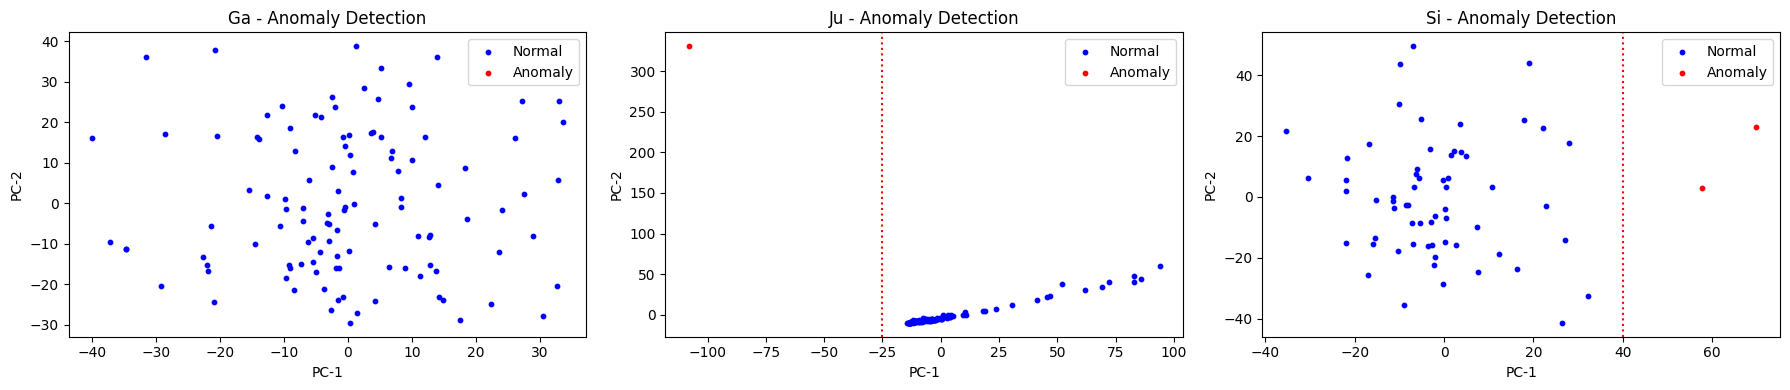

Saved in: anomaly_detection


In [10]:
plot_anomaly_detection_GaJuSi(dataset_person, outlier_thresh_map={
    'Ga': (None, None),
    'Ju': (-25, None),
    'Si': (40, None),
})